# Phase 1: Exploratory Data Analysis (EDA)
**Goal:** Identify the problem by analyzing the linguistic structural differences between Official Protocol (Minutes/Speeches) and Spontaneous Communication (Press Conf Q&A).

## Objectives
1.  **Data Volume Analysis:** How much data do we have per source?
2.  **Length Analysis:** Are Q&A answers significantly longer/different than scripted sentences?
3.  **Vocabulary Overlap:** Do they use the same words?
4.  **Temporal Distribution:** How is the data spread over time?

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os

sns.set(style='whitegrid', font_scale=1.2)
pd.set_option('display.max_columns', None)

# Load Data
DATA_PATH = '../data/master/fed_master_corpus.csv'
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    df['date'] = pd.to_datetime(df['date'])
    print(f"Loaded {len(df)} records.")
else:
    print("Data file not found. Run export_data.py first.")

Loaded 6602 records.


## 1. Data Distribution by Source

In [2]:
# 假设你已经加载了 df_master
speech_counts = df[df['source'] == 'Speech'].groupby(df['date'].dt.year).size()
print(speech_counts)

date
2018    466
2019    512
2020    174
2021    180
2022    206
2023    209
2024    187
dtype: int64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_42972\3084193751.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='source', data=df, palette='viridis')


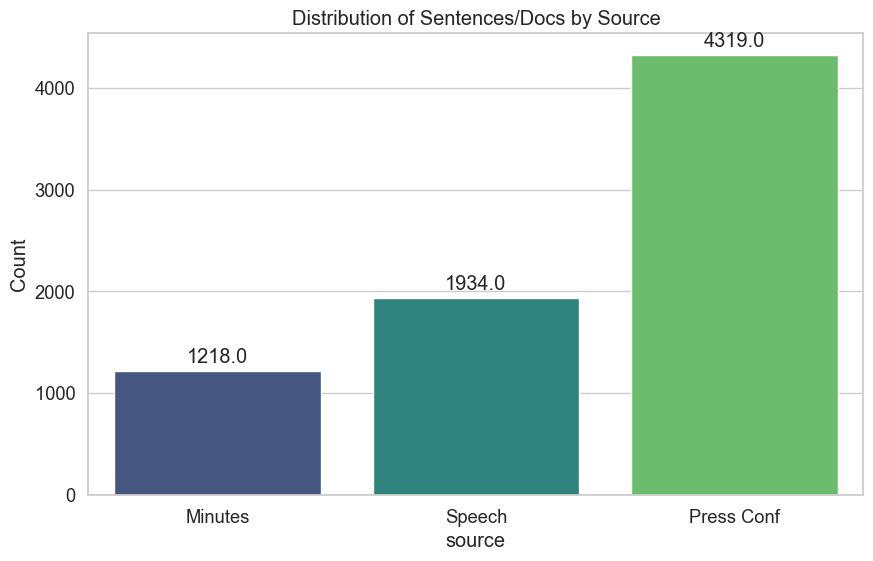

In [3]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='source', data=df, palette='viridis')
plt.title('Distribution of Sentences/Docs by Source')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

## 2. Text Length Distributions (The "Granularity Gap")
We suspect that Press Conf data might be less segmented (paragraphs) compared to Speeches (sentences).

C:\Users\Administrator\AppData\Local\Temp\ipykernel_42972\1752555912.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='source', y='word_count', data=df, palette='Set2')


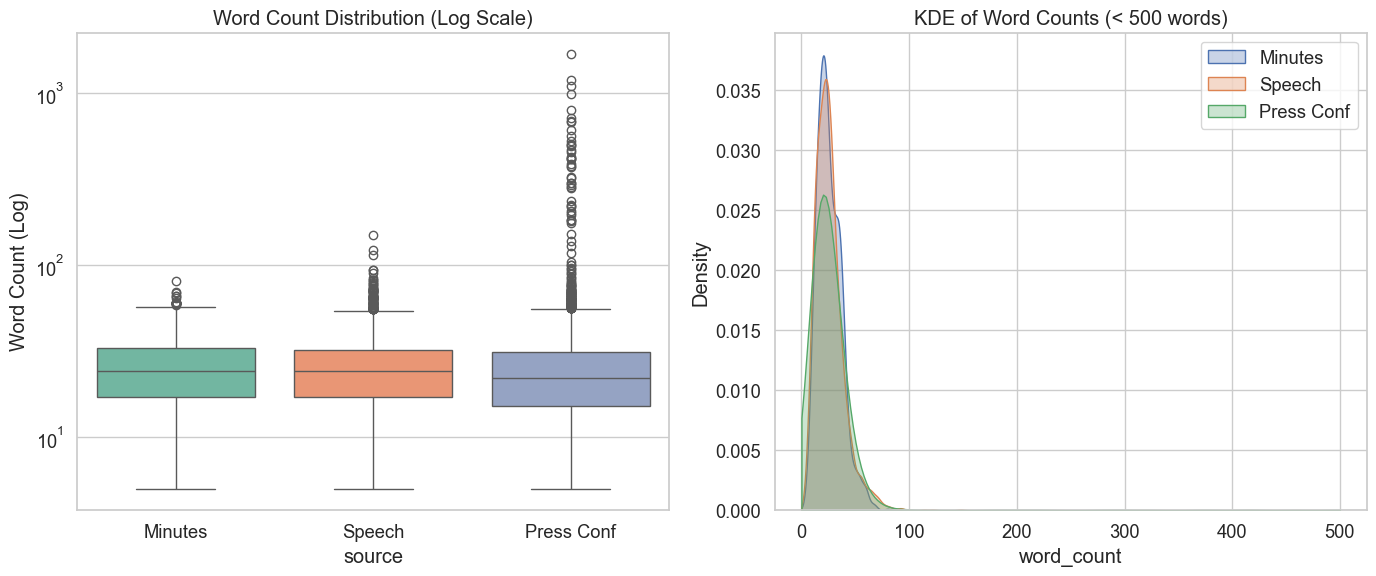

             count       mean        std  min   25%   50%   75%     max
source                                                                 
Minutes     1218.0  25.784893  11.296470  5.0  17.0  24.0  33.0    80.0
Press Conf  4319.0  28.540171  53.691757  5.0  15.0  22.0  31.0  1671.0
Speech      1934.0  25.897622  13.544350  5.0  17.0  24.0  32.0   148.0


In [4]:
plt.figure(figsize=(14, 6))

# Boxplot (Log scale to handle outliers)
plt.subplot(1, 2, 1)
sns.boxplot(x='source', y='word_count', data=df, palette='Set2')
plt.yscale('log')
plt.title('Word Count Distribution (Log Scale)')
plt.ylabel('Word Count (Log)')

# Histograms
plt.subplot(1, 2, 2)
for source in df['source'].unique():
    subset = df[df['source'] == source]
    sns.kdeplot(subset['word_count'], label=source, clip=(0, 500), fill=True, alpha=0.3)
plt.title('KDE of Word Counts (< 500 words)')
plt.legend()

plt.tight_layout()
plt.show()

# Print Stats
print(df.groupby('source')['word_count'].describe())

## 3. Top Keywords (Word Clouds)
Visualizing the distinct vocabulary of each mode.

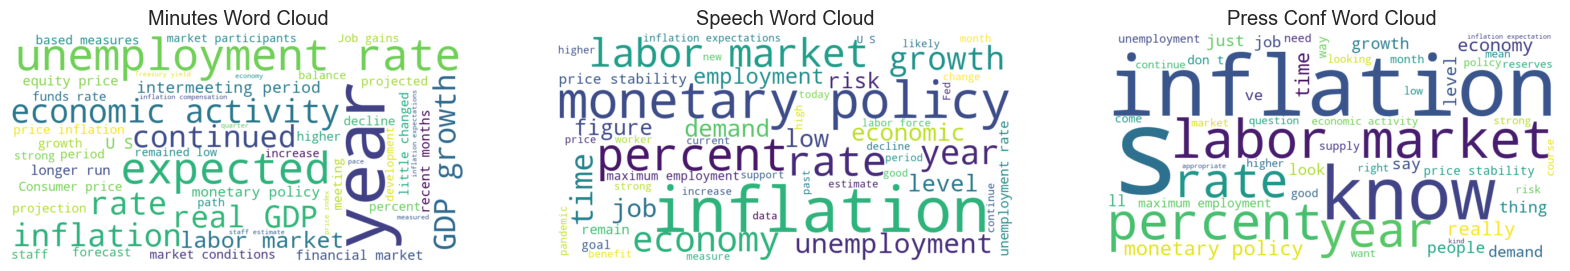

In [5]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = list(ENGLISH_STOP_WORDS) + ['federal', 'reserve', 'chair', 'chairman', 'think', 'going', 'fomc']

sources = df['source'].unique()
plt.figure(figsize=(20, 6))

for i, source in enumerate(sources):
    text = " ".join(df[df['source'] == source]['text'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, max_words=50).generate(text)
    
    plt.subplot(1, 3, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{source} Word Cloud")

plt.show()

## 4. Jaccard Similarity Analysis
How much does the vocabulary overlap?

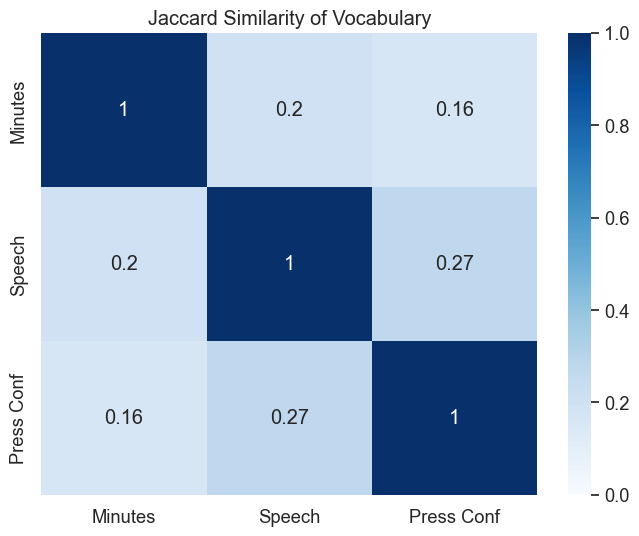

In [6]:
def get_vocab(text_series):
    text = " ".join(text_series.astype(str)).lower()
    words = set(text.split())
    return words

vocabs = {}
for source in sources:
    vocabs[source] = get_vocab(df[df['source'] == source]['text'])

matrix = pd.DataFrame(index=sources, columns=sources)
for s1 in sources:
    for s2 in sources:
        v1 = vocabs[s1]
        v2 = vocabs[s2]
        jaccard = len(v1.intersection(v2)) / len(v1.union(v2))
        matrix.loc[s1, s2] = jaccard

plt.figure(figsize=(8, 6))
sns.heatmap(matrix.astype(float), annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title('Jaccard Similarity of Vocabulary')
plt.show()